[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rsarka34/RDLINet/blob/main/model/RDLINet.ipynb)

# **RDLINet: A Novel Lightweight Inception Network for Respiratory Disease Classification Using Lung Sounds**

**Authors: Arka Roy, Udit Satija**

[RDLINet Paper Link: https://ieeexplore.ieee.org/document/10174701](https://ieeexplore.ieee.org/document/10174701)

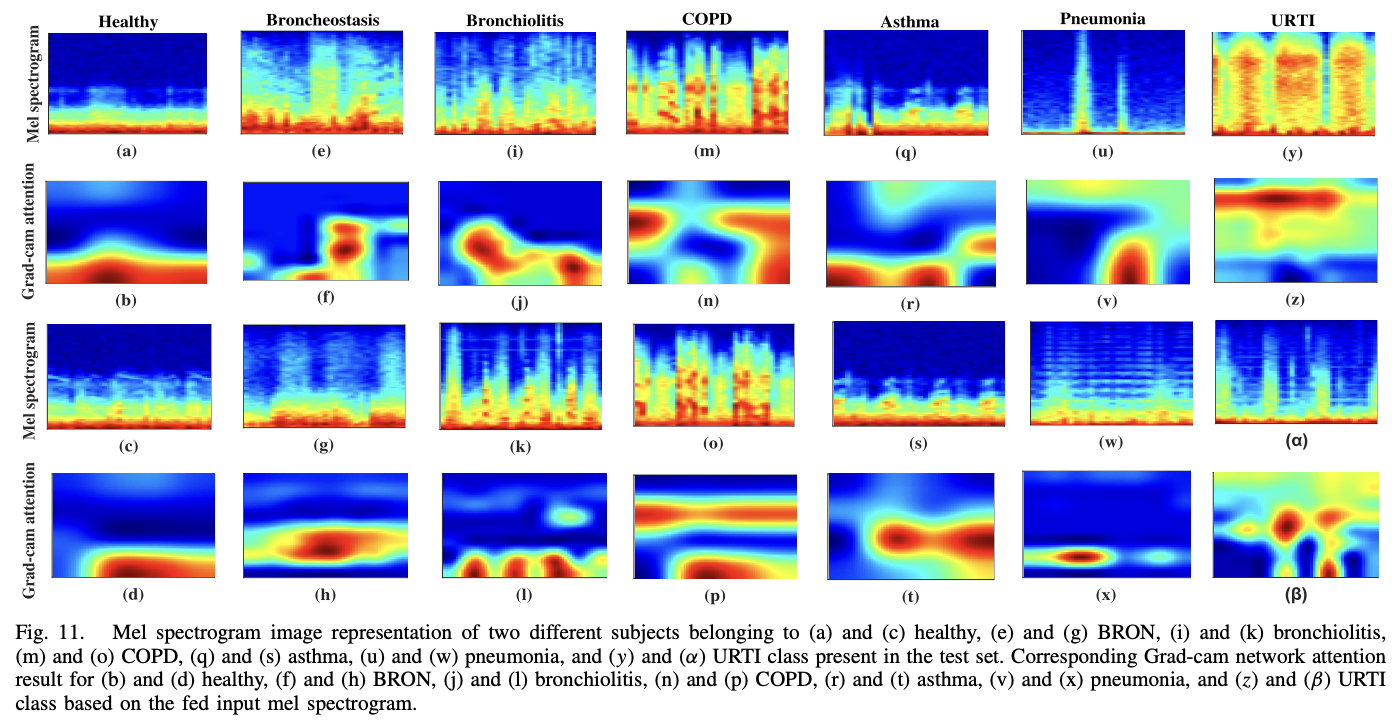

# **Import Libraries**

In [ ]:
mport pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.figure
from pathlib import Path
import os
import wave
import keras
import seaborn as sns
import librosa
import soundfile as sf
from google.colab import drive
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from numpy import mean
from numpy import std
import tensorflow as tf
from numpy import dstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tqdm import tqdm
import os
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print(keras.__version__)
!pip install mat73
import mat73

drive.mount('/content/gdrive')

import scipy.io as sio

# **Load Data and Labels**

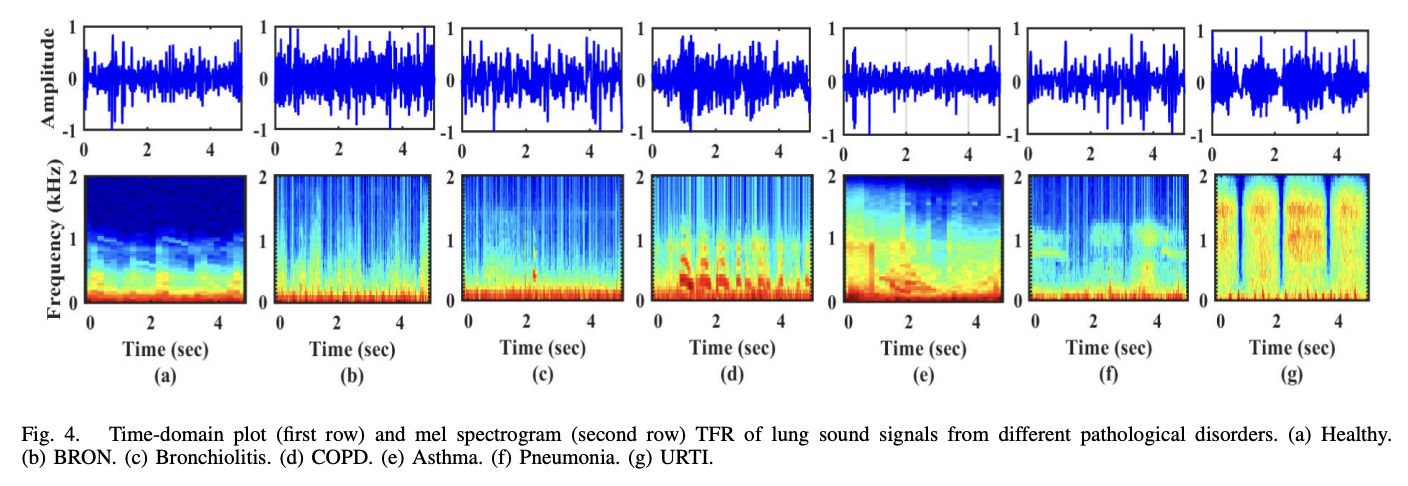

In [ ]:
sig_dict = sio.loadmat('/content/gdrive/MyDrive/7clss_orig_dim/imgs_64_38.mat')
X=sig_dict['train_img']

labels=pd.read_excel('/content/gdrive/MyDrive/7clss_orig_dim/7class_labels.xlsx',header=None)
labels.columns=["Lung Sound"]
class_label_onehot=pd.get_dummies(labels)
Y=np.array(class_label_onehot);
print(X.shape)
print(Y.shape)

(18905, 64, 38, 3)
(18905, 7)


# **Build RDLINet**

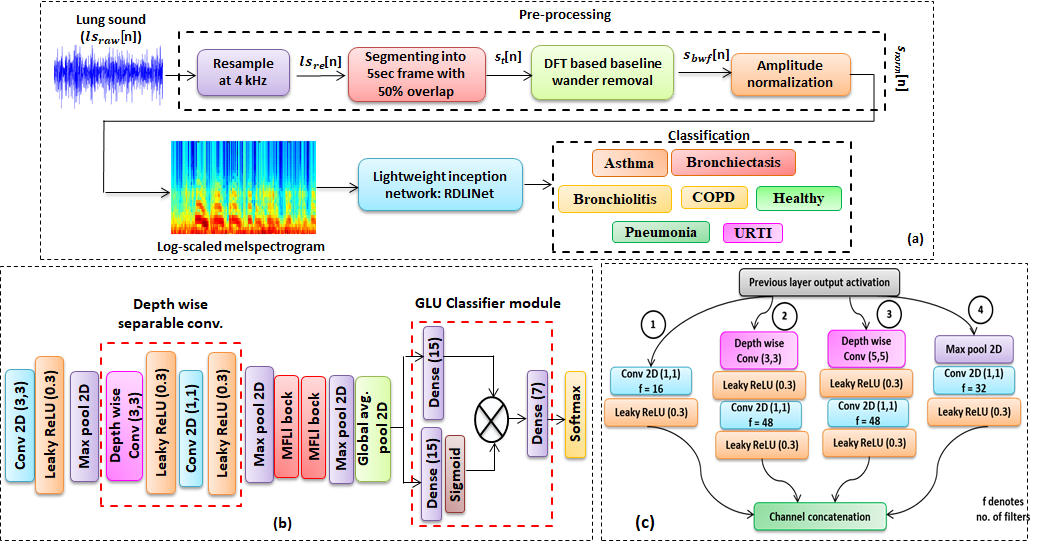

In [ ]:
def RDLINet(dim, output_neurons, output_activation):
    print("\nTRAINING ON RDLINet:-")

    def block(x, filters, reps):
        for _ in range(reps):
            # for low-level features
            t1 = Conv2D(filters[0], kernel_size = (1,1))(x)
            t1 = LeakyReLU()(t1)

            t2 = DepthwiseConv2D(kernel_size = (3,3), strides = 1, padding = 'same')(x)
            t2 = LeakyReLU()(t2)
            t2 = Conv2D(filters[1], kernel_size = (1,1))(t2)
            t2 = LeakyReLU()(t2)

            t3 = DepthwiseConv2D(kernel_size = (5,5), strides = 1, padding = 'same')(x)
            t3 = LeakyReLU()(t3)
            t3 = Conv2D(filters[2], kernel_size = (1,1))(t3)
            t3 = LeakyReLU()(t3)

            t4 = MaxPool2D(pool_size = (3,3), strides = 1, padding = 'same')(x)
            t4 = Conv2D(filters[3], kernel_size = (1,1))(t4)
            t4 = LeakyReLU()(t4)

            x = Concatenate()([t1, t2, t3, t4])

        return x


    input = Input(shape = dim)

    k = 16

    x = Conv2D(filters = k, kernel_size = (3,3), strides = 2, padding = 'same')(input)
    x = LeakyReLU()(x)
    x = MaxPool2D(pool_size = (3,3), strides = 2, padding = 'same')(x)

    x = DepthwiseConv2D(kernel_size = (3,3), strides = 1, padding = 'same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters = 2*k, kernel_size = (1,1))(x)
    x = LeakyReLU()(x)
    x = MaxPool2D(pool_size = (2,2), strides = 2)(x)

    x = block(x, [k, k, k, k], reps = 2)
    x = MaxPool2D(pool_size = (2,2), strides = 2)(x)

    x = GlobalAveragePooling2D()(x)
    t1= Dense(15, 'sigmoid')(x)
    t2= Dense(15,'linear')(x)
    t3=Multiply()([t1,t2])

    output = Dense(output_neurons, output_activation)(t3)

    model = Model(inputs = input, outputs = output)

    return model
dim = (64,38,3)
output_neurons = 7
output_activation = 'softmax'
from keras import backend as Ke
Ke.clear_session()
model = RDLINet(dim, output_neurons, output_activation)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 38, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 19, 16)   448         ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 19, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 10, 16)   0           ['leaky_re_lu[0][0]']            
                                                                                              

# **Train RDLINet**

In [ ]:
p=1;batch=256;
print('Random_seed_value== '+str(p))
X_train_1,X_test,Y_train_1,Y_test=train_test_split(X,Y,test_size=0.1,random_state=p)
X_train,X_val,Y_train,Y_val=train_test_split(X_train_1,Y_train_1,test_size=0.1,random_state=p)

print("================================================================================================")
opt =tf.keras.optimizers.Adam(learning_rate=0.008)
custom_early_stopping=tf.keras.callbacks.EarlyStopping(
monitor="val_accuracy",
patience=30,
verbose=1,
mode="auto",
baseline=0.92,
restore_best_weights=False,
start_from_epoch=170,
)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=128, epochs=300, verbose=1,validation_data=(X_val, Y_val),callbacks=[custom_early_stopping])

Epoch 1/300
120/120 [==============================] - 9s 16ms/step - loss: 1.6413 - accuracy: 0.3730 - val_loss: 1.5469 - val_accuracy: 0.4078
Epoch 2/300
120/120 [==============================] - 1s 11ms/step - loss: 1.4161 - accuracy: 0.4413 - val_loss: 1.2977 - val_accuracy: 0.4818
Epoch 3/300
120/120 [==============================] - 1s 11ms/step - loss: 1.1210 - accuracy: 0.5603 - val_loss: 1.0841 - val_accuracy: 0.5458
Epoch 4/300
120/120 [==============================] - 1s 11ms/step - loss: 0.9256 - accuracy: 0.6320 - val_loss: 0.9974 - val_accuracy: 0.6046
Epoch 5/300
120/120 [==============================] - 1s 12ms/step - loss: 0.8149 - accuracy: 0.6748 - val_loss: 0.7762 - val_accuracy: 0.7150
Epoch 6/300
120/120 [==============================] - 2s 15ms/step - loss: 0.6904 - accuracy: 0.7286 - val_loss: 0.6598 - val_accuracy: 0.7391
Epoch 7/300
120/120 [==============================] - 2s 15ms/step - loss: 0.6368 - accuracy: 0.7460 - val_loss: 0.6173 - val_accuracy:

# **Test Results**

## **Confusion matrices**

In [ ]:
results=model.evaluate(X_test,Y_test,batch_size=128,verbose=1)
print('Test loss:', results[0])
print('Test accuracy:', results[1])
predicted=model.predict(X_test,batch_size=128,verbose=1)
Y_pred=predicted.argmax(axis=-1)
Y_pred=predicted.argmax(axis=-1)
Y_predicted=pd.DataFrame(Y_test,
                          columns=['Asthma','Broncheostasis','Bronchiolitis',
                                  'COPD','Healthy','Pneumonia','URTI'])
Y_ori=[];Asthma_t=0;Broncheostasis_t=0;Bronchiolitis_t=0;
COPD_t=0;Healthy_t=0;Pneumonia_t=0;URTI_t=0;
for index,row in tqdm(Y_predicted.iterrows()):
    if row['Asthma']==1:
      Asthma_t=Asthma_t+1
      Y_ori.append(0)
    elif row['Broncheostasis']==1:
      Broncheostasis_t=Broncheostasis_t+1
      Y_ori.append(1)
    elif row['Bronchiolitis']==1:
      Bronchiolitis_t=Bronchiolitis_t+1
      Y_ori.append(2)
    elif row['COPD']==1:
      COPD_t=COPD_t+1
      Y_ori.append(3)
    elif row['Healthy']==1:
      Healthy_t=Healthy_t+1
      Y_ori.append(4)
    elif row['Pneumonia']==1:
      Pneumonia_t=Pneumonia_t+1
      Y_ori.append(5)
    elif row['URTI']==1:
      URTI_t=URTI_t+1
      Y_ori.append(6)

cm=confusion_matrix(Y_ori,Y_pred)
cm_norm=confusion_matrix(Y_ori,Y_pred,normalize='true')
print('Confusion Matrix');
print(cm)

cm_df = pd.DataFrame(cm,index = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'],
                      columns = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'])
plt.figure(100)
plt.figure(figsize=(20,6))
plt.subplot(121)
sns.heatmap(cm_df,annot=True,cmap="OrRd")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

cm_df_norm = pd.DataFrame(cm_norm, index = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'],
                          columns = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'])
plt.subplot(122)
sns.heatmap(cm_df_norm,annot=True,cmap="OrRd")
plt.title('Normalised Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## **TSNE plots**

[Text(0.5, 1.0, 'T-SNE projection ')]

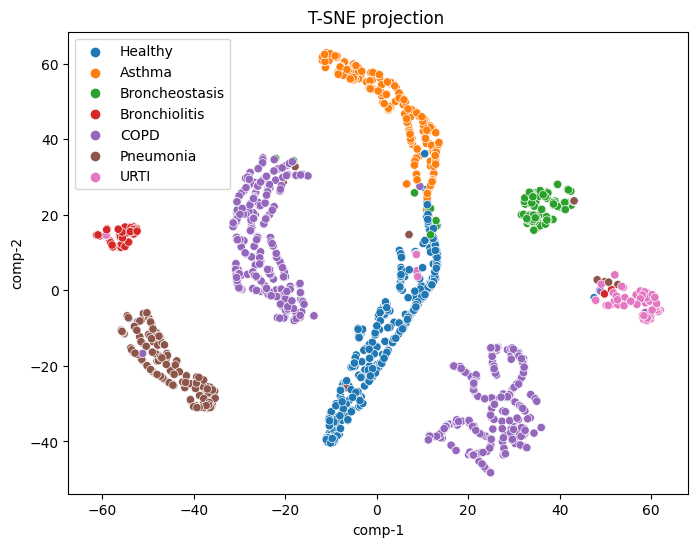

In [ ]:
from tensorflow.keras.models import Model
out_dense= Model(inputs=model.input,outputs=model.get_layer('dense_2').output)
Y_denseout = out_dense.predict(X_test)
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,learning_rate='auto',init='random')
Y_embedded = tsne.fit_transform(Y_denseout)


Y_predicted=pd.DataFrame(Y_test,columns=['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'])
Y_ori=[];Asthma_t=0;Broncheostasis_t=0;Bronchiolitis_t=0;COPD_t=0;Healthy_t=0;Pneumonia_t=0;URTI_t=0;
for index,row in tqdm(Y_predicted.iterrows()):
   if row['Asthma']==1:
     Asthma_t=Asthma_t+1
     Y_ori.append(0)
   elif row['Broncheostasis']==1:
      Broncheostasis_t=Broncheostasis_t+1
      Y_ori.append(1)
   elif row['Bronchiolitis']==1:
      Bronchiolitis_t=Bronchiolitis_t+1
      Y_ori.append(2)
   elif row['COPD']==1:
       COPD_t=COPD_t+1
       Y_ori.append(3)
   elif row['Healthy']==1:
       Healthy_t=Healthy_t+1
       Y_ori.append(4)
   elif row['Pneumonia']==1:
       Pneumonia_t=Pneumonia_t+1
       Y_ori.append(5)
   elif row['URTI']==1:
      URTI_t=URTI_t+1
      Y_ori.append(6)


q=np.array(Y_ori)
label_l=[]
for i in range (X_test.shape[0]):
  if q[i]==0:
    label_l.append('Asthma')
  elif q[i]==1:
    label_l.append('Broncheostasis')
  elif q[i]==2:
    label_l.append('Bronchiolitis')
  elif q[i]==3:
    label_l.append('COPD')
  elif q[i]==4:
    label_l.append('Healthy')
  elif q[i]==5:
    label_l.append('Pneumonia')
  elif q[i]==6:
    label_l.append('URTI')

Label_ar=np.array(label_l)
df = pd.DataFrame()
df["Labels"] = Label_ar
df["comp-1"] = Y_embedded[:,0]
df["comp-2"] = Y_embedded[:,1]
import seaborn as sns
plt.figure(figsize=(8,6))
sns.scatterplot(x="comp-1", y="comp-2", hue=df.Labels.tolist(),
                data=df).set(title="T-SNE projection ")

## **ROC curves**

In [ ]:
from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
Y_ori=np.array(Y_ori)
n_classes = 7 # number of class
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_ori, Y_softmax[:,i],pos_label=i )
    roc_auc[i] = auc(fpr[i], tpr[i])
p=[]
for i in range (7):
  p.append(roc_auc[i])
p=np.array(p)
p_rounded=np.round(p,decimals=3)

(0.5, 1.04)

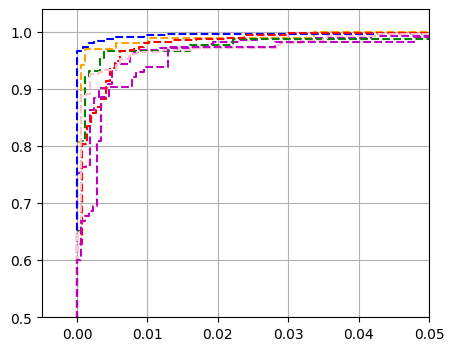

In [ ]:
plt.figure(figsize=(5,4))
plt.plot(fpr[0], tpr[0], linestyle='--',color='m')
plt.plot(fpr[1], tpr[1], linestyle='--',color='orange')
plt.plot(fpr[2], tpr[2], linestyle='--',color='green')
plt.plot(fpr[3], tpr[3], linestyle='--',color='blue')
plt.plot(fpr[4], tpr[4], linestyle='--',color='red')
plt.plot(fpr[5], tpr[5], linestyle='--',color='pink')
plt.plot(fpr[6], tpr[6], linestyle='--',color='m')
plt.xlim([-0.005,0.05]); plt.grid()
plt.ylim([0.5,1.04])

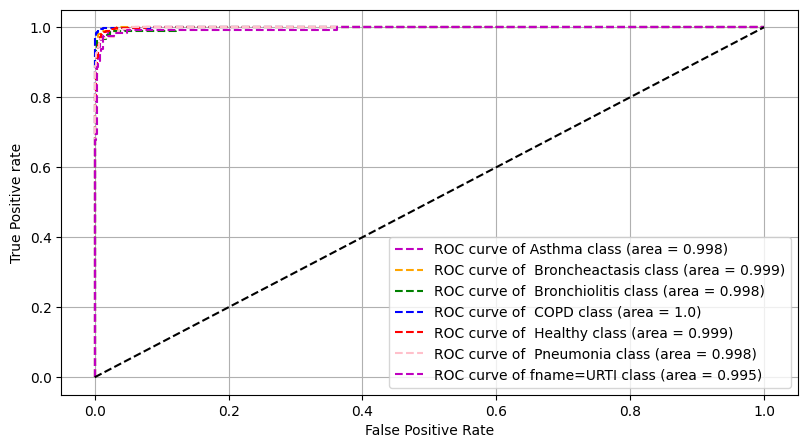

In [ ]:
# Plot the ROC chart
plt.figure(figsize=(9.5,5))
plt.plot(fpr[0], tpr[0], linestyle='--',color='m', label='ROC curve of Asthma class (area = '+str(p_rounded[0])+')')
plt.plot(fpr[1], tpr[1], linestyle='--',color='orange', label= 'ROC curve of  Broncheactasis class (area = '+str(p_rounded[1])+')')
plt.plot(fpr[2], tpr[2], linestyle='--',color='green', label='ROC curve of  Bronchiolitis class (area = '+str(p_rounded[2])+')')
plt.plot(fpr[3], tpr[3], linestyle='--',color='blue', label='ROC curve of  COPD class (area = '+str(p_rounded[3])+')')
plt.plot(fpr[4], tpr[4], linestyle='--',color='red', label='ROC curve of  Healthy class (area = '+str(p_rounded[4])+')')
plt.plot(fpr[5], tpr[5], linestyle='--',color='pink', label='ROC curve of  Pneumonia class (area = '+str(p_rounded[5])+')')
plt.plot(fpr[6], tpr[6], linestyle='--',color='m', label='ROC curve of fname=URTI class (area = '+str(p_rounded[6])+')')
plt.plot([0, 1], [0, 1], 'k--');plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()